## <font color='darkblue'>Preface</font>
([article source](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec)) The code described below is now available as a pip package — https://pypi.org/project/heatmapz/. There’s also a Google Colab notebook [here](https://colab.research.google.com/drive/1YSvER-U3cwGplSHyXwaCXYhOWfWO53Iy), you can see a few examples in there and play around with the lib

## <font color='darkblue'>Correlation Matrix plots</font>
You already know that if you have a data set with many columns, **a good way to quickly check correlations among columns is by visualizing the correlation matrix as a heatmap.**

But is a simple heatmap the best way to do it?

For illustration, I’ll use the [Automobile Data Set](http://archive.ics.uci.edu/ml/datasets/automobile), containing various characteristics of a number of cars. You can also find a clean version of the data with header columns [here](https://github.com/drazenz/heatmap/blob/master/autos.clean.csv).

Let’s start by making a correlation matrix heatmap for the data set.

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Step 0 - Read the dataset, calculate column correlations and make a seaborn heatmap
plt.rcParams['figure.figsize'] = [10, 6]
data = pd.read_csv('https://raw.githubusercontent.com/drazenz/heatmap/master/autos.clean.csv')
data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,122,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


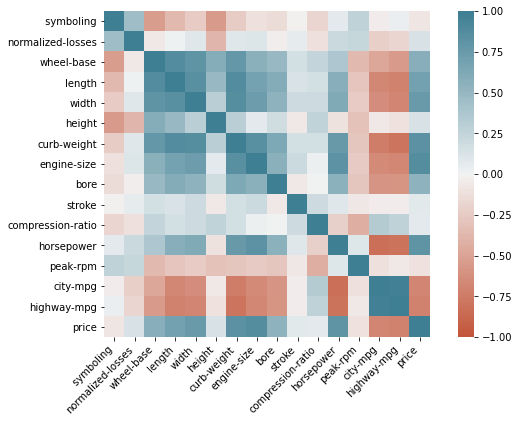

In [4]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Great! **Green means positive, red means negative. The stronger the color, the larger the correlation magnitude**. Now looking at the chart above, think about the following questions:
* Where do your eyes jump first when you look at the chart?
* What’s the strongest and what’s the weakest correlated pair (<font color='brown'>except the main diagonal</font>)?
* What are the three variables most correlated with `price`?

If you’re like most people, you’ll find <font color='darkred'>**it hard to map the color scale to numbers and vice versa**</font>.

Distinguishing positive from negative is easy, as well as 0 from 1. But what about the second question? Finding the highest negative and positive correlations mean finding the strongest red and green. To do that I need to carefully scan the entire grid. Try to answer it again and notice how your eyes are jumping around the plot, and sometimes going to the legend.

Now consider the following plot:
![1.png](images/1.png)
<br/>
In addition to color, we’ve added size as a parameter to our heatmap. The size of each square corresponds to the magnitude of the correlation it represents, that is $size(c1, c2) = abs(corr(c1, c2))$

Now try to answer the questions using the latter plot. **Notice how weak correlations visually disappear, and your eyes are immediately drawn to areas where there’s high correlation**. Also note that it’s now easier to compare magnitudes of negative vs positive values (<font color='brown'>lighter red vs lighter green</font>), and we can also compare values that are further apart.

**If we’re mapping magnitudes, it’s much more natural to link them to the size of the representing object than to its color**. That’s exactly why on bar charts you would use height to display measures, and colors to display categories, but not vice versa.

## <font color='darkblue'>Discrete Joint Distributions</font>
Let’s see **how the cars in our data set are distributed according to `horsepower` and `drive-wheels` layout**. That is, we want to visualize the following table

In [31]:
from collections import defaultdict

data['hp_rank'] = data.apply(
    lambda r: 'Low (0-100)' if r.horsepower <= 100 else 'Medium (100-150)' if r.horsepower <= 150 else 'High (150+)',
    axis=1
)

data['value'] = 1
pd.pivot_table(data, values='value', columns=['drive-wheels'], index='hp_rank', fill_value=0, aggfunc=np.sum)

drive-wheels,4wd,fwd,rwd
hp_rank,,,
High (150+),0,5,25
Low (0-100),5,89,15
Medium (100-150),3,24,35


Consider the following two ways to do it:
![2.png](images/2.png)
<br/>
The second version, where we **use square size to display counts makes it effortless to determine which group is the largest/smallest.** It also gives some intuition about the marginal distributions, all without needing to refer to a color legend.

## <font color='darkblue'>Great. So how do I make these plots?</font>
To make a regular heatmap, we simply used the [**Seaborn heatmap function**](https://seaborn.pydata.org/generated/seaborn.heatmap.html), with a bit of additional styling.

For the second kind, there’s no trivial way to make it using Matplotlib or Seaborn. We could use [corrplot from biokit](https://nbviewer.jupyter.org/github/biokit/biokit/blob/master/notebooks/viz/corrplot.ipynb), but it helps with correlations only and isn’t very useful for two-dimensional distributions.

Building a robust parametrized function that enables us to make heatmaps with sized markers is a nice exercise in Matplotlib, so I’ll show you how to do it step by step.

We’ll start by using a simple scatter plot with squares as markers. Then we’ll fix some issues with it, add color and size as parameters, make it more general and robust to various types of input, and finally **make a wrapper function corrplot that takes a result of [DataFrame.corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) method and plots a correlation matrix, supplying all the necessary parameters to the more general heatmap function.**

### <font color='darkgreen'>It’s just a scatter plot</font>
If we want to plot elements on a grid made by two categorical axes, we can use a scatter plot.

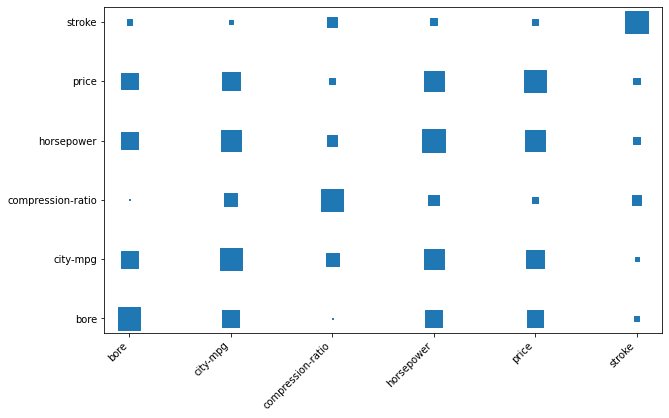

In [32]:
# Step 1 - Make a scatter plot with square markers, set column names as labels

def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
data = pd.read_csv('https://raw.githubusercontent.com/drazenz/heatmap/master/autos.clean.csv')
columns = ['bore', 'stroke', 'compression-ratio', 'horsepower', 'city-mpg', 'price'] 
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

Looks like we’re onto something. But I said it’s just a scatterplot, and there’s quite a lot happening in the previous code snippet.

Since the scatterplot requires <i>x</i> and <i>y</i> to be numeric arrays, we need to map our column names to numbers. And since we want our axis ticks to show column names instead of those numbers, we need to set custom `ticks` and `ticklabels`. Finally there’s code that loads the dataset, selects a subset of columns, calculates all the correlations, melts the data frame (<font color='brown'>the inverse of creating a pivot table</font>) and feeds its columns to our `heatmap` function.

You noticed that our squares are placed where our gridlines intersect, instead of being centered in their cells. **In order to move the squares to cell centers, we’ll actually move the grid. And to move the grid, we’ll actually turn off major gridlines, and set minor gridlines to go right in between our axis ticks.**
```python
ax.grid(False, 'major')
ax.grid(True, 'minor')
ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
```

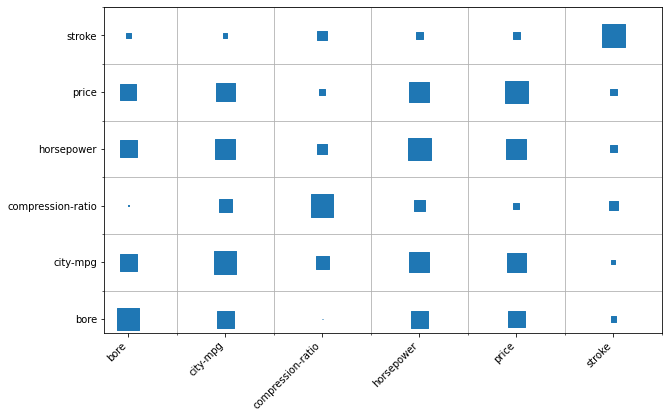

In [33]:
def heatmap_v2(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
heatmap_v2(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

That’s better. But now the left and bottom side look cropped. That’s because our axis lower limit are set to 0. We’ll sort this out by setting the lower limit for both axes to — 0.5. Remember, our points are displayed at integer coordinates, so our gridlines are at .5 coordinates.
```python
ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
```

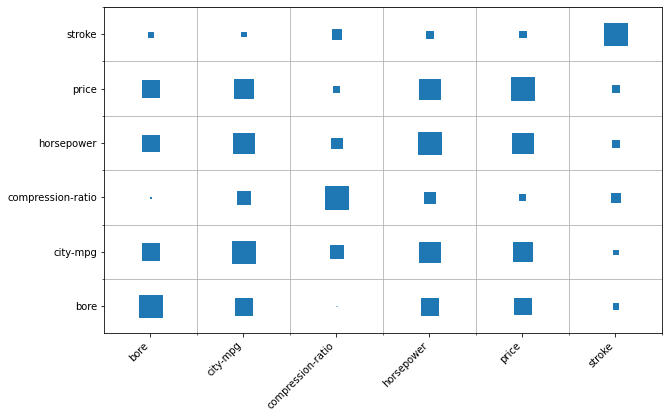

In [35]:
def heatmap_v3(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
heatmap_v3(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

### <font color='darkgreen'>Give it some color</font>
Now comes the fun part. We need to map the possible range of values for correlation coefficients, `[-1, 1]`, to a color palette. We’ll use a diverging palette, going from red for -1, all the way to green for 1. Looking at [**Seaborn color palettes**](https://seaborn.pydata.org/tutorial/color_palettes.html), seems that we’ll do just fine with something like:

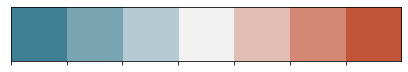

In [36]:
sns.palplot(sns.diverging_palette(220, 20, n=7))

But lets first flip the order of colors and make it smoother by adding more steps between red and green:

In [37]:
palette = sns.diverging_palette(20, 220, n=256)

**Seaborn color palettes are just arrays of color components**, so in order to map a correlation value to the appropriate color, we need to ultimately map it to an index in the palette array. It’s a simple mapping of one interval to another: $[-1, 1] → [0, 1] → (0, 255)$. More precisely, here’s the sequence of steps this mapping will take:
![3.png](images/3.png)
<br/>
```python
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

ax.scatter(
    x=x.map(x_to_num),
    y=y.map(y_to_num),
    s=size * size_scale,
    c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
    marker='s'
)
```

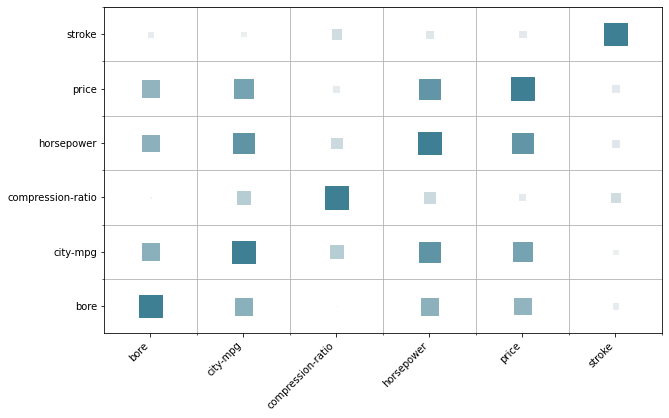

In [42]:
def heatmap_v4(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]

    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size * size_scale,
        c=size.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s'
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
heatmap_v4(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

Just what we wanted. Let’s now add a color bar on the right side of the chart. We’ll use GridSpec to set up a plot grid with 1 row and n columns. Then we’ll use the rightmost column of the plot to display the color bar and the rest to display the heatmap.

There are multiple ways to display a color bar, here we’ll trick our eyes by using a really dense bar chart. We’ll draw `n_colors` horizontal bars, each colored with its respective color from the palette:
```python
plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot

ax.scatter(
    x=x.map(x_to_num), # Use mapping for x
    y=y.map(y_to_num), # Use mapping for y
    s=size * size_scale, # Vector of square sizes, proportional to size parameter
    c=color.apply(value_to_color), # Vector of square colors, mapped to color palette
    marker='s' # Use square as scatterplot marker
)
# ...

# Add color legend on the right side of the plot
ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

col_x = [0]*len(palette) # Fixed x coordinate for the bars
bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

bar_height = bar_y[1] - bar_y[0]
ax.barh(
    y=bar_y,
    width=[5]*len(palette), # Make bars 5 units wide
    left=col_x, # Make bars start at 0
    height=bar_height,
    color=palette,
    linewidth=0
)
ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
ax.grid(False) # Hide grid
ax.set_facecolor('white') # Make background white
ax.set_xticks([]) # Remove horizontal ticks
ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
ax.yaxis.tick_right() # Show vertical ticks on the right 
```
<br/>

![4.png](images/4.png)
<br/>

And we have our color bar.

We’re almost done. **Now we should just flip the vertical axis so that we get correlation of each variable with itself shown on the main diagonal, make squares a bit larger and make the background a just a tad lighter so that values around 0 are more visible.**

But let’s first make the entire code more useful.

### <font color='darkgreen'>More parameters!</font>
It would be great if we made our function able to accept more than just a correlation matrix. To do this we’ll make the following changes:
* Be able to pass `color_min`, `color_max` and `size_min`, `size_max` as parameters so that we can map different ranges than $[-1, 1]$ to color and size. This will enable us to use the heatmap beyond correlations
* Use a sequential palette if no palette specified, use a single color if no color vector provided
* Use a constant size if no size vector provided. Avoid mapping the lowest value to 0 size.
* Make <i>x</i> and <i>y</i> the only necessary parameters, and pass `size`, `color`, `size_scale`, `size_range`, `color_range`, `palette`, `marker` as kwargs. Provide sensible defaults for each of the parameters
* Use list comprehensions instead pandas <font color='blue'>apply</font> and <font color='blue'>map</font> methods, so we can pass any kind of arrays as <i>x</i>, <i>y</i>, `color`, `size` instead of just [**pandas.Series**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)
* Pass any other kwargs to pyplot.scatterplot function
* Make a wrapper function corrplot that accepts a [corr()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) dataframe, melts it, calls heatmap with a red-green diverging color palette, and size/color min-max set to $[-1, 1]$

That’s quite a lot of boilerplate stuff to cover step by step, so below what it looks like when done. You can also check it out in this [**Kaggle kernel**](https://www.kaggle.com/drazen/heatmap-with-sized-markers).

In [44]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

### <font color='darkgreen'>Finally</font>
Now that we have our <font color='blue'>corrplot</font> and <font color='blue'>heatmap</font> functions, in order to create the correlation plot with sized squares, like the one at the beginning of this post, we simply do the following:

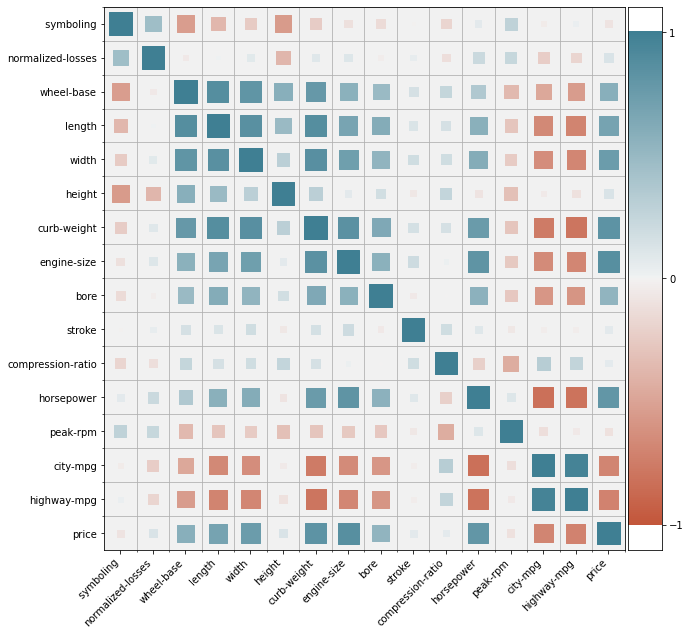

In [45]:
plt.figure(figsize=(10, 10))
corrplot(data.corr())

And just for fun, let’s **make a plot showing how engine power is distributed among car brands in our data set**:

In [46]:
bin_labels = ['Low (0-100)', 'Medium (100-150)', 'High (150+)']
data['horsepower-group'] = pd.cut(
    data['horsepower'],
    bins=[0, 100, 150, data['horsepower'].max()],
    labels=bin_labels
)
data[['horsepower', 'horsepower-group']].head(n=10)

,horsepower,horsepower-group
0,111.0,Medium (100-150)
1,111.0,Medium (100-150)
2,154.0,High (150+)
3,102.0,Medium (100-150)
4,115.0,Medium (100-150)
5,110.0,Medium (100-150)
6,110.0,Medium (100-150)
7,110.0,Medium (100-150)
8,140.0,Medium (100-150)
9,101.0,Medium (100-150)


In [49]:
data['cnt'] = np.ones(len(data))
g = data.groupby(['horsepower-group', 'make']).count()[['cnt']].reset_index().replace(np.nan, 0)
g

,horsepower-group,make,cnt
0,Low (0-100),alfa-romero,0.0
1,Low (0-100),audi,0.0
2,Low (0-100),bmw,0.0
3,Low (0-100),chevrolet,3.0
4,Low (0-100),dodge,6.0
...,...,...,...
61,High (150+),saab,2.0
62,High (150+),subaru,0.0
63,High (150+),toyota,4.0
64,High (150+),volkswagen,0.0


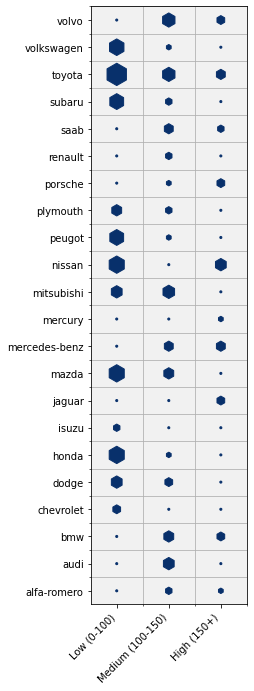

In [50]:
plt.figure(figsize=(3, 11))
heatmap(
    x=g['horsepower-group'],
    y=g['make'],
    size=g['cnt'],
    marker='h',
    x_order=bin_labels
)

That concludes the story on this simple idea for improving heatmap visualizations.

## <font color='darkblue'>Curious for more?</font>
If you want to learn about applications of data science in the real world, checkout the [**Data Science topic on Blogboard**](https://blogboard.io/topic/Data%20Science). Blogboard is a tool I built to help me discover industry blogs on topics I most care about.

I also summarize lessons from the industry on Blogboard Journal, where you can find articles such as Data Science for Marketing Optimization — Case Studies from Airbnb, Lyft, Doordash: